# Load Dataset

In [1]:
%pip install pyspark
%pip install seaborn
%pip install seaborn matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import split, col, count, when, sum, expr, udf
from pyspark.sql.types import FloatType, DoubleType
from pyspark.sql.window import Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from google.colab import files

In [3]:
# ignore this please dont delete:

import shutil
total, used, free = shutil.disk_usage("C:/")
print(f"Free space on C: {round(free / (1024**3), 2)} GB")


Free space on C: 62.72 GB


In [4]:
import os
from pyspark.sql import SparkSession

# Set Java path (make sure it's Java 8)
os.environ["JAVA_HOME"] = r"C:\Program Files\Eclipse Adoptium\jdk-8.0.442.6-hotspot"
os.environ["PATH"] = os.environ["JAVA_HOME"] + r"\bin;" + os.environ["PATH"]

# Set Spark memory and temp dir
spark = SparkSession.builder \
    .appName("Malware Network Traffic") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.local.dir", "C:/tmp_spark") \
    .getOrCreate()

print("✅ Spark session created.")

✅ Spark session created.


In [6]:
# Path to the file (same folder as notebook)
file_path = "dataset_malware.csv" # change name if needed

# Load the CSV into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True, sep="|")

# Light Data Exploration

## Display first 5 rows in dataset

In [7]:
# print(df_split.head())
# Show first 5 rows
df.show(5)

+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|                 ts|               uid|    id.orig_h|id.orig_p|     id.resp_h|id.resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|          label|detailed-label|
+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|1.545402842863612E9|CdNmOg26ZIaBRzPvWj|192.168.1.196|  59932.0|104.248.160.24|     80.0|  tcp|      -|3.097754|         0|         0|        S0|      

## Show schema to identify column types

In [ ]:
df.printSchema()

root
 |-- ts: double (nullable = true)
 |-- uid: string (nullable = true)
 |-- id.orig_h: string (nullable = true)
 |-- id.orig_p: double (nullable = true)
 |-- id.resp_h: string (nullable = true)
 |-- id.resp_p: double (nullable = true)
 |-- proto: string (nullable = true)
 |-- service: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- orig_bytes: string (nullable = true)
 |-- resp_bytes: string (nullable = true)
 |-- conn_state: string (nullable = true)
 |-- local_orig: string (nullable = true)
 |-- local_resp: string (nullable = true)
 |-- missed_bytes: double (nullable = true)
 |-- history: string (nullable = true)
 |-- orig_pkts: double (nullable = true)
 |-- orig_ip_bytes: double (nullable = true)
 |-- resp_pkts: double (nullable = true)
 |-- resp_ip_bytes: double (nullable = true)
 |-- tunnel_parents: string (nullable = true)
 |-- label: string (nullable = true)
 |-- detailed-label: string (nullable = true)



## Check number of rows and columns

In [ ]:
num_rows = df.count()
print(f"Number of rows: {num_rows}")
num_columns = len(df.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 10447787
Number of columns: 23


# Data Cleaning

## Cast '-' to NaN change column names so that Spark will not misinterpret them

In [8]:
from pyspark.sql.functions import col, when

for column in df.columns:
    df = df.withColumn(column, when(col(f"`{column}`") == "-", None).otherwise(col(f"`{column}`")))

# Rename columns to replace dots with underscores
new_column_names = [c.replace(".", "_") for c in df.columns]
df = df.toDF(*new_column_names)

# Check
df.show(5)

+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|                 ts|               uid|    id_orig_h|id_orig_p|     id_resp_h|id_resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|          label|detailed-label|
+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|1.545402842863612E9|CdNmOg26ZIaBRzPvWj|192.168.1.196|  59932.0|104.248.160.24|     80.0|  tcp|   NULL|3.097754|         0|         0|        S0|      

## Dealing with missing values

In [9]:
from pyspark.sql.functions import col, sum as spark_sum

null_values = (
    df.select([
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in df.columns
    ])
    .toPandas()
    .T.rename(columns={0: "Count"})
)

display(null_values)

,Count
ts,0
uid,0
id_orig_h,0
id_orig_p,0
id_resp_h,0
id_resp_p,0
proto,0
service,10446261
duration,4432615
orig_bytes,4432615


Since duration, orig_bytes, resp_bytes all have same number of null values (4432615), very likely they are from the same few rows. All three columns are critical for modelling so it is best to drop the rows containing null values in those fields.

Others like service, local_orig, local_resp, tunnel_parents amd detailed_label all have more than 10446261 out of 10447787 null values. These will not help our model and will just bloat memory, so we can drop these columns.

In [10]:
from pyspark.sql.functions import when, col

# Columns you care about
columns_to_clean = ['duration', 'orig_bytes', 'resp_bytes', 'history']

# Replace "NULL" or "null" strings with actual nulls (None)
for c in columns_to_clean:
    df = df.withColumn(c, when((col(c) == "NULL") | (col(c) == "null"), None).otherwise(col(c)))

# Now drop rows where any of these are null
df = df.dropna(subset=columns_to_clean)

from pyspark.sql.functions import col, sum as spark_sum

# now drop columns with largely null values
columns_to_drop = ["service", "local_orig", "local_resp", "tunnel_parents", "detailed-label"]
df = df.drop(*columns_to_drop)


null_values = (
    df.select([
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in df.columns
    ])
    .toPandas()
    .T.rename(columns={0: "Count"})
)

display(null_values)

,Count
ts,0
uid,0
id_orig_h,0
id_orig_p,0
id_resp_h,0
id_resp_p,0
proto,0
duration,0
orig_bytes,0
resp_bytes,0


They are indeed from the same few rows. now there are 0 NULL count for duration, orig_bytes and resp_bytes.

## check number of rows and colums after dropping rows with null values

In [11]:
num_rows = df.count()
print(f"Number of rows: {num_rows}")
num_columns = len(df.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 6015150
Number of columns: 18


# Deeper Data Exploration

## Checking for Distribution of Target Variable


In [12]:
# Register DataFrame as a SQL table
df.createOrReplaceTempView("malware_data")

# Define SQL Query to count the number of rows with 0 and 1 in the target variable
query = """
SELECT
    label,
    COUNT(*) AS count
FROM
    malware_data
GROUP BY
    label
"""

# Run the SQL query
result = spark.sql(query)
result.show()

+------------------+-------+
|             label|  count|
+------------------+-------+
|   Malicious   C&C|     33|
|            Benign|4108318|
|Malicious   Attack|      3|
|  Malicious   DDoS|1906796|
+------------------+-------+



In [13]:
# DROPPING ROWS WITH VERY LOW FREQUENCY --------------------------------
df = df.filter(~col("label").isin("Malicious   Attack", "Malicious   C&C"))

Check distribution again:

In [14]:
# Register DataFrame as a SQL table
df.createOrReplaceTempView("malware_data")

# Define SQL Query to count the number of rows with 0 and 1 in the target variable
query = """
SELECT
    label,
    COUNT(*) AS count
FROM
    malware_data
GROUP BY
    label
"""

# Run the SQL query
result = spark.sql(query)
result.show()

+----------------+-------+
|           label|  count|
+----------------+-------+
|          Benign|4108318|
|Malicious   DDoS|1906796|
+----------------+-------+



Roughly 2:1 ratio, mildly imbalanced.

## Performing Stratified Undersampling of majority benign class

In [15]:
# Split the data set according to the target variable
malware_df = df.filter(col("label") == "Malicious   DDoS")
benign_df = df.filter(col("label") == "Benign")

benign_strata_counts = benign_df.groupBy("conn_state").count().collect()

target_total = 2000000
total_benign = benign_df.count()

# Turn list of Rows into a Python dict for easier access
stratum_counts = {row['conn_state']: row['count'] for row in benign_strata_counts}

# Calculate sampling fraction per category
sampling_fractions = {
    k: (count / total_benign) * target_total / count
    for k, count in stratum_counts.items()
}

# Sample the data set according to the calculated sampling fractions
sampled_benign_df = benign_df.sampleBy("conn_state", fractions=sampling_fractions, seed=42)

# Union the sampled benign data with the malware data and create a new DataFrame
final_balanced_df = sampled_benign_df.union(malware_df)
df = final_balanced_df
 
# ---------------------------------------------------------Show distribution of new undersampled data set -------------------------------------

# Register DataFrame as a SQL table
df.createOrReplaceTempView("malware_data")

# Define SQL Query to count the number of rows with 0 and 1 in the target variable
sampled_query = """
SELECT
    label,
    COUNT(*) AS count
FROM
    malware_data
GROUP BY
    label
"""

# Run the SQL query
result = spark.sql(sampled_query)
result.show()

+----------------+-------+
|           label|  count|
+----------------+-------+
|          Benign|2001051|
|Malicious   DDoS|1906796|
+----------------+-------+



## Summary statistics for numeric columns

In [17]:
# convert numerical columns
cols_to_convert = [
    "duration", "orig_bytes", "resp_bytes",
    "missed_bytes", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes"
]

# Convert to FloatType
for column in cols_to_convert:
    df = df.withColumn(column, col(column).cast(FloatType()))

# Descriptive stats with Pandas for nicer formatting
desc_stats = df.select(cols_to_convert).summary().toPandas()
desc_stats_pd = desc_stats.set_index('summary').rename_axis(None, axis=1).T
display(desc_stats_pd)

summary,count,mean,stddev,min,25%,50%,75%,max
duration,3908415,4.818827012530115,12.193839220853286,2.0E-6,3.09399,3.132466,3.707644,582.169
orig_bytes,3908415,5.47913679869496E8,4.289701267674327E9,0.0,0.0,0.0,0.0,6.6205577E10
resp_bytes,3908415,489.28767057745915,965527.3881510182,0.0,0.0,0.0,0.0,1.9088195E9
missed_bytes,3908415,488.394506724593,965527.2098585557,0.0,0.0,0.0,0.0,1.9088195E9
orig_pkts,3908415,8.14891714416202,3722.912249777925,1.0,3.0,3.0,3.0,4027345.0
orig_ip_bytes,3908415,320.80812707964736,104241.92884383083,49.0,120.0,180.0,180.0,1.1276566E8
resp_pkts,3908415,0.0011953694784202803,0.4197843492185459,0.0,0.0,0.0,0.0,279.0
resp_ip_bytes,3908415,0.96240496467238,613.0211744706407,0.0,0.0,0.0,0.0,413488.0


## Boxplots for numerical variables

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use your actual numeric variables (but check for existence)
all_numeric_cols = [
    "duration", "orig_bytes", "resp_bytes",
    "missed_bytes", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes"
]

# Filter only columns that exist in df
numeric_cols = [col_name for col_name in all_numeric_cols if col_name in df.columns]

# Optional: handle nulls before collecting (replace with 0 or drop rows)
from pyspark.sql.functions import when, isnan

for col_name in numeric_cols:
    df = df.withColumn(col_name, when(
        (col(col_name).isNull()) | (isnan(col(col_name))), 0
    ).otherwise(col(col_name)))

# Sample to avoid memory issues (optional)
df_sample = df.select(numeric_cols).sample(False, 0.5, seed=42)

# Convert to pandas for plotting
df_pandas = df_sample.toPandas()

# Plot boxplots
num_cols = 5
num_vars = len(numeric_cols)
num_rows = (num_vars + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
axes = axes.flatten()

for i, col_name in enumerate(numeric_cols):
    sns.boxplot(x=df_pandas[col_name], ax=axes[i], color='skyblue')
    axes[i].set_title(col_name)
    axes[i].set_xlabel("")  # cleaner look

# Remove empty plots
for i in range(num_vars, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\jessi\Desktop\BT4221\maleware-detection-ml-model\.venv\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "c:\Users\jessi\Desktop\BT4221\maleware-detection-ml-model\.venv\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\jessi\AppData\Local\Programs\Python\Python313\Lib\socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

## Categorical Value Distibution

In [19]:
categorical_cols = ["proto", "conn_state", "history"]

for col in categorical_cols:
    count_df = df.groupBy(col).count().orderBy("count", ascending=False).toPandas()
    print(f"=== {col} Value Counts ===")
    display(count_df)


=== proto Value Counts ===


,proto,count
0,tcp,3907526
1,udp,889


=== conn_state Value Counts ===


,conn_state,count
0,S0,2000316
1,RSTOS0,1841172
2,OTH,65535
3,REJ,933
4,SF,393
5,RSTO,27
6,RSTR,16
7,S1,12
8,S2,7
9,SH,2


=== history Value Counts ===


,history,count
0,S,1999765
1,I,1841162
2,DTT,65534
3,Sr,932
4,D,551
5,Dd,338
6,ShADdfFa,13
7,ShAdDaTR,12
8,ShAfFa,12
9,ShAdDaR,10


In [20]:
from pyspark.sql.functions import countDistinct

# Count distinct values for each column
cardinality = df.select(
    countDistinct("id_orig_h").alias("id_orig_h_cardinality"),
    countDistinct("id_orig_p").alias("id_orig_p_cardinality"),
    countDistinct("id_resp_h").alias("id_resp_h_cardinality"),
    countDistinct("id_resp_p").alias("id_resp_p_cardinality")
).collect()[0]

# Print the cardinality of each column
print(f"Cardinality of id_orig_h: {cardinality['id_orig_h_cardinality']}")
print(f"Cardinality of id_orig_p: {cardinality['id_orig_p_cardinality']}")
print(f"Cardinality of id_resp_h: {cardinality['id_resp_h_cardinality']}")
print(f"Cardinality of id_resp_p: {cardinality['id_resp_p_cardinality']}")

Cardinality of id_orig_h: 3
Cardinality of id_orig_p: 65536
Cardinality of id_resp_h: 1998985
Cardinality of id_resp_p: 10


id_orig_h has low cardinality -> 28, so likely represent small number of internal source IPs (devices on your network)

id_resp_p has low cardinality -> 16 destination ports, likely standard ones like 80, 443, 22. tells you what kind of service was accessed. 

## Correlation matrix for numeric columns

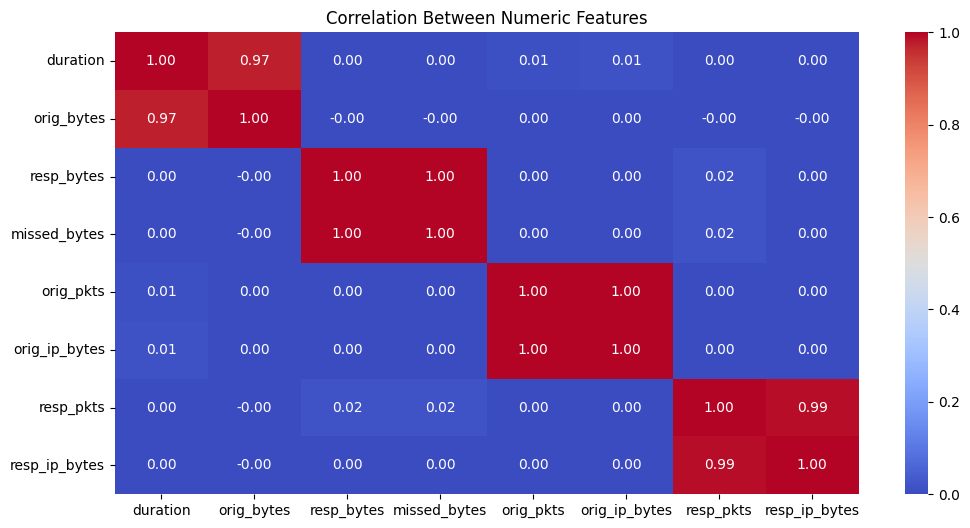

In [21]:
from pyspark.sql.types import FloatType, DoubleType

# Define numeric features to keep (excluding ID-like columns)
numeric_cols = [
    "duration", "orig_bytes", "resp_bytes",
    "missed_bytes", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes"
]

# Convert PySpark DataFrame to pandas DataFrame for correlation calculation
pandas_df = df.select(numeric_cols).toPandas()

# Plot correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pandas_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.show()

From the correlation matrix, it can be seen that:
1. Strong Positive Correlation (Close to 1.0)
  - `resp_bytes` and `resp_ip_bytes` are similarly strongly correlated (0.98). This could also mean one of the columns might be redundant.
  - `duration` and `resp_pkts` are also strongly correlated (0.95). This makes sense as longer durations correlate with more response packets, indicating sustained communication during the duration.
2. Weak/Negligible Correlations (Close to 0):
  - Port numbers (`id.orig_p`, `id.resp_p`) have near-zero correlations with other features suggesting that ports do not directly influence traffic metrics (e.g. duration, bytes). This is expected as ports are identifiers, not quantitative measures.
  - Except for its strong positive correlation to `resp_ip_bytes`, `resp_bytes` and most other features have weak/negligible correlations (0.00-0.21) possibly indicating isolated response behaviors.

## Mutual Information Scoring

In [ ]:
# Discretise numerical features
numeric_cols = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'double', 'float']]

# compute mutual info
def compute_mutual_info(df, feature_col, target_col="label", n_bins=5):
    # 5 quantile based bins per numerical col
    if feature_col in numeric_cols:
        df = df.withColumn(
            f"{feature_col}_bin",
            F.ntile(n_bins).over(Window.orderBy(feature_col)))
        feature_col = f"{feature_col}_bin"

    # Compute joint probability P(X,Y)
    joint_prob = (
        df.groupBy(feature_col, target_col)
        .agg(F.count("*").alias("count"))
        .withColumn("p_xy", F.col("count") / df.count())
    )

    # Compute marginal probabilities P(X) and P(Y)
    p_x = joint_prob.groupBy(feature_col).agg(F.sum("p_xy").alias("p_x"))
    p_y = joint_prob.groupBy(target_col).agg(F.sum("p_xy").alias("p_y"))

    # Calculate MI terms: p_xy * log2(p_xy / (p_x * p_y))
    mi_terms = (
        joint_prob.join(p_x, feature_col)
        .join(p_y, target_col)
        .withColumn(
            "mi_term",
            F.col("p_xy") * F.log2(F.col("p_xy") / (F.col("p_x") * F.col("p_y")))
        )
    )

    # Sum MI terms to get final score
    mi = mi_terms.agg(F.sum("mi_term").alias("mi")).collect()[0]["mi"]
    return float(mi) if mi else 0.0

# Compute MI for all features
df_mis = df.select("*")
mi_results = {}

for feature in df_mis.columns:  # Combine all features
    if feature == "label":
        continue
    mi_score = compute_mutual_info(df_mis, feature)
    mi_results[feature] = mi_score
    print(f"MI for {feature}: {mi_score:.4f}")

# Sort the MI and display results
sorted_mi_results = sorted(mi_results.items(), key=lambda x: x[1], reverse=True)
print("\n=== Features sorted by Mutual Information ===")
for feature, mi_score in sorted_mi_results:
    print(f"{feature}: {mi_score:.4f}")

MI for ts: 0.3668
MI for uid: 0.9996
MI for id_orig_h: 0.0000
MI for id_orig_p: 0.2570
MI for id_resp_h: 0.9996
MI for id_resp_p: 0.7279
MI for proto: 0.0002
MI for duration: 0.6271
MI for orig_bytes: 0.7990
MI for resp_bytes: 0.8005
MI for conn_state: 0.9993
MI for missed_bytes: 0.0017
MI for history: 0.9993
MI for orig_pkts: 0.5076
MI for orig_ip_bytes: 0.6428
MI for resp_pkts: 0.0017
MI for resp_ip_bytes: 0.0017

=== Features sorted by Mutual Information ===
id_resp_h: 0.9996
uid: 0.9996
history: 0.9993
conn_state: 0.9993
resp_bytes: 0.8005
orig_bytes: 0.7990
id_resp_p: 0.7279
orig_ip_bytes: 0.6428
duration: 0.6271
orig_pkts: 0.5076
ts: 0.3668
id_orig_p: 0.2570
missed_bytes: 0.0017
resp_pkts: 0.0017
resp_ip_bytes: 0.0017
proto: 0.0002
id_orig_h: 0.0000


**Interpretation of Mutual Information (MI) Scoring:**

MI scoring is a measure of how much information one variable (feature) provides about another (target variable, in this case, `label`). It helps identify which features are most relevant for predicting the target, where a higher MI score means the feature is more informative for the prediction and should be prioritised for model training.

From the results:
The top 5 informative features are
1. `id_resp_h` (0.901)
2. `uid` (0.901)
3. `history` (0.901)
4. `conn_state` (0.901)
5. `id_resp_p` (0.640)

On the other hand, the features with low/zero MI score are `proto` (0.0002) and `id_orig_h` (0.000) which have very low MI and may have a negligible effect on prediction.

**Data Leakage Issue** - to edit

While `uid` has a high MI score, it could suggest that the `uid` is leaking information about the `label` as `uid` is supposed to be a unique identifier for the connection. Since it is unique per row, it has zero predictive power on new data and cannot be generalised onto new samples. This could cause the model to perform extremely well on training data but fail on unseen data.

# Feature Engineering

## Engineering new Meaningful Features

In [16]:
# NEW VERSION
from pyspark.sql.functions import col, when, lit, log1p

df = df \
    .withColumn("total_bytes", col("orig_bytes") + col("resp_bytes")) \
    .withColumn("byte_ratio", col("orig_bytes") / (col("resp_bytes") + lit(1))) \
    .withColumn("pkt_ratio", col("orig_pkts") / (col("resp_pkts") + lit(1))) \
    .withColumn("total_pkts", col("orig_pkts") + col("resp_pkts")) \
    .withColumn("throughput", col("total_bytes") / (col("duration") + lit(1e-6))) \
    .withColumn("efficiency", col("total_bytes") / (col("total_pkts") + lit(1)))

df.select("total_bytes", "byte_ratio", "pkt_ratio", "total_pkts", "throughput", "efficiency").show(5)

+-----------+------------------+---------+----------+------------------+----------+
|total_bytes|        byte_ratio|pkt_ratio|total_pkts|        throughput|efficiency|
+-----------+------------------+---------+----------+------------------+----------+
|       96.0|0.9795918367346939|      0.5|       2.0| 668.2956372825429|      32.0|
|       78.0|              78.0|      2.0|       2.0|15.599497696174183|      26.0|
|       78.0|              78.0|      2.0|       2.0|15.583973441712542|      26.0|
|       78.0|              78.0|      2.0|       2.0|15.583923624389081|      26.0|
|       78.0|              78.0|      2.0|       2.0|15.583960987351817|      26.0|
+-----------+------------------+---------+----------+------------------+----------+
only showing top 5 rows



## Label Indexing and Train Data Splitting

In [17]:
from pyspark.ml.feature import StringIndexer

# Create a label indexer for string labels.
label_indexer = StringIndexer(inputCol="label", outputCol="label_index", handleInvalid="keep")

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

## Encoding of Categorical Variables:

Categorical varaiables included are History, proto, conn_state, and id_resp_p. From data exploration, cardinality of each of them are 61, 3, 11, 16 respectively.

History has high cardinality so need to do frequency encoding.
Others have relative low cardinality so one-hot encoding is feasible.

In [18]:
# NEW VERSION - HIGH CARDINALITY
from pyspark.sql.functions import count

# for high cardinality categorical features, use frequency encoding

history_freq_train = train_df.groupBy("history").count().withColumnRenamed("count", "history_freq")

# Join the frequency mapping to the training data.
train_df = train_df.join(history_freq_train, on="history", how="left")

# Join the same mapping to the test data.
test_df = test_df.join(history_freq_train, on="history", how="left")
# Fill null values in test set for unseen "history" categories (if any) with 0.
test_df = test_df.fillna({"history_freq": 0.0})

In [19]:
# NEW VERSION - LOW CARDINALITY
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Low-cardinality categorical features to one-hot encode:
low_card_cat = ["proto", "conn_state", "id_resp_p"]

# Create StringIndexers for low-cardinality features.
indexers = [StringIndexer(inputCol=cat, outputCol=cat + "_index", handleInvalid="keep")
            for cat in low_card_cat]

# Create OneHotEncoders for the indexed features.
encoders = [OneHotEncoder(inputCol=cat + "_index", outputCol=cat + "_vec")
            for cat in low_card_cat]

## Scaling of Numerical Features

In [20]:
# NEW VERSION
from pyspark.ml.feature import VectorAssembler, StandardScaler

# List of numerical features to scale.
numeric_features = ["duration", "byte_ratio", "pkt_ratio",
                    "total_bytes", "total_pkts", "efficiency", "throughput", "history_freq"]

# Ensure numeric feature columns are of type double.
for feature in numeric_features:
    train_df = train_df.withColumn(feature, col(feature).cast("double"))
    test_df = test_df.withColumn(feature, col(feature).cast("double"))

# Assemble numeric features into a vector.
assembler_num = VectorAssembler(inputCols=numeric_features, outputCol="num_features")

# Scale numerical features using StandardScaler.
scaler = StandardScaler(inputCol="num_features", outputCol="features_scaled")

## Assemble Features for Modelling

In [21]:
# NEW VERSION
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

final_features = ["features_scaled"] + [cat + "_vec" for cat in low_card_cat] + ["history_freq"]

final_assembler = VectorAssembler(
    inputCols=final_features,
    outputCol="features", handleInvalid="skip"
)

# Model Training and Evaluation

## Logistic Regression

In [22]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

lr = LogisticRegression(featuresCol="features", labelCol="label_index", maxIter=20, regParam=0.1)

pipeline = Pipeline(stages=[label_indexer] + indexers + encoders + [assembler_num, scaler, final_assembler, lr])

In [23]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Setup parameter grid for Logistic Regression.
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0]) \
    .build()

# Define evaluator using area under ROC.
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", 
    predictionCol="prediction", # default is "prediction"
    metricName="accuracy")

# Setup 3-fold cross-validation.
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

# Train the model using cross-validation on the training set.
cvModel = cv.fit(train_df)

In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd

# Make predictions on the test set
predictions = cvModel.transform(test_df)

# === 1. Accuracy ===
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

print(f"Test Accuracy     : {accuracy:.4f}")

Test Accuracy     : 1.0000


In [28]:
# === 2. Precision (weighted) ===
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)

print(f"Test Precision    : {precision:.4f}")

Test Precision    : 1.0000


In [31]:
# === 3. Recall (weighted) ===
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)

print(f"Test Recall       : {recall:.4f}")

Test Recall       : 1.0000


In [30]:
# === 4. F1 Score (weighted) ===
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)


print(f"Test F1 Score     : {f1:.4f}")

Test F1 Score     : 1.0000


In [38]:
# === 5. Confusion Matrix ===
from pyspark.sql.functions import col
import pandas as pd

# Group and count predictions vs labels
conf_df = predictions.groupBy("label_index", "prediction").count().toPandas()

# Pivot to confusion matrix format
matrix = conf_df.pivot(index="label_index", columns="prediction", values="count").fillna(0).astype(int)

matrix.index = [f"Actual {int(i)}" for i in matrix.index]
matrix.columns = [f"Predicted {int(i)}" for i in matrix.columns]

# Step 4: Add totals
matrix["Total Actual"] = matrix.sum(axis=1)
matrix.loc["Total Predicted"] = matrix.sum()

# Step 5: Print nicely
print("Confusion Matrix:\n")
print(matrix.to_string())

📊 Confusion Matrix:

                 Predicted 0  Predicted 1  Total Actual
Actual 0              399756            1        399757
Actual 1                   9       382132        382141
Total Predicted       399765       382133        781898


## Random Forest

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label_index",
    numTrees=10,  
    maxDepth=5    
)

rf_pipeline = Pipeline(stages=[label_indexer] + indexers + encoders + [assembler_num, scaler, final_assembler, rf])

In [31]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 10]) \
    .addGrid(rf.maxDepth, [3, 5]) \
    .build()

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label_index",  
    predictionCol="prediction",  
    metricName="accuracy"  
)
cv = CrossValidator(
    estimator=rf_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator_acc,
    numFolds=3,
    parallelism=1
)

cv_model = cv.fit(train_df)
rf_predictions = cv_model.bestModel.transform(test_df)

rf_accuracy = evaluator_acc.evaluate(rf_predictions)
print(f"RF Accuracy: {rf_accuracy:.4f}")

RF Accuracy: 1.0000


In [32]:
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label_index",
    rawPredictionCol="prediction", 
    metricName="areaUnderROC"
)

rf_auc = evaluator_auc.evaluate(rf_predictions)
print(f"RF AUC: {rf_auc:.4f}")

RF AUC: 1.0000


In [44]:
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction",
    metricName="weightedRecall"
)

rf_recall = evaluator_recall.evaluate(rf_predictions)
print(f"RF recall: {rf_recall:.4f}")

RF recall: 1.0000


In [45]:
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

rf_precision = evaluator_precision.evaluate(rf_predictions)
print(f"RF precision: {rf_precision:.4f}")

RF precision: 1.0000


In [41]:
rf_predictions.select("label", "label_index", "probability", "prediction").show(5, truncate=False)

+------+-----------+---------------------------------------------+----------+
|label |label_index|probability                                  |prediction|
+------+-----------+---------------------------------------------+----------+
|Benign|0.0        |[0.7967963078820495,0.20320369211795053,0.0] |0.0       |
|Benign|0.0        |[0.9960374537346904,0.003962546265309587,0.0]|0.0       |
|Benign|0.0        |[0.9960374537346904,0.003962546265309587,0.0]|0.0       |
|Benign|0.0        |[0.9960374537346904,0.003962546265309587,0.0]|0.0       |
|Benign|0.0        |[0.9960374537346904,0.003962546265309587,0.0]|0.0       |
+------+-----------+---------------------------------------------+----------+
only showing top 5 rows



In [43]:
confusion_matrix = rf_predictions.groupBy("label_index").pivot("prediction").count().na.fill(0)
confusion_matrix.show()

+-----------+------+------+
|label_index|   0.0|   1.0|
+-----------+------+------+
|        0.0|400456|     2|
|        1.0|     0|381048|
+-----------+------+------+



## Gradient Boosted Trees

In [ ]:
# Gradient boosted tree is binary

from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

# gbt regressor
gbt = GBTClassifier(featuresCol="features",
                    labelCol="label_index")

gbt_pipeline = Pipeline(stages=[label_indexer] + indexers + encoders + [assembler_num, scaler, final_assembler, gbt])

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the Parameter Grid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 50]) \
    .addGrid(gbt.maxDepth, [3, 5]) \
    .build()

# Evaluation
# evaluate AUC using BinaryClassificationEvaluator
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label_index",
    rawPredictionCol="rawPrediction",  # GBT outputs rawPrediction
    metricName="areaUnderROC"
)

cv_gbt = CrossValidator(estimator=gbt_pipeline,
                        estimatorParamMaps=paramGrid_gbt,
                        evaluator = evaluator_auc,
                        numFolds=2)

cv_model_gbt = cv_gbt.fit(train_df)
best_gbt_model = cv_model_gbt.bestModel

best_gbt_predictions = best_gbt_model.transform(test_df)

best_gbt_predictions.select("label", "label_index", "probability", "prediction").show(5, truncate=False)

+------+-----------+----------------------------------------+----------+
|label |label_index|probability                             |prediction|
+------+-----------+----------------------------------------+----------+
|Benign|0.0        |[0.9341221756527827,0.06587782434721734]|0.0       |
|Benign|0.0        |[0.9341221756527827,0.06587782434721734]|0.0       |
|Benign|0.0        |[0.9341221756527827,0.06587782434721734]|0.0       |
|Benign|0.0        |[0.9341221756527827,0.06587782434721734]|0.0       |
|Benign|0.0        |[0.9341221756527827,0.06587782434721734]|0.0       |
+------+-----------+----------------------------------------+----------+
only showing top 5 rows



In [ ]:
# EValuate using AUC
gbt_auc = evaluator_auc.evaluate(best_gbt_predictions)
print(f"GBT AUC: {gbt_auc:.4f}")

# Evaluate using Accuracy.
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(best_gbt_predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate using F1 Score.
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(best_gbt_predictions)
print(f"Test F1 Score: {f1:.4f}")

GBT AUC: 1.0000
Test Accuracy: 1.0000
Test F1 Score: 1.0000


In [ ]:
# OLD VERSION
# Gradient boosted tree is binary

from pyspark.ml.classification import GBTClassifier
# from pyspark.ml import Pipeline
df_model = df

df_model = df_model.drop("label_index") # force drop existing when rerunning the cell

df_model = df_model.withColumn(
    "label",
    when(col("label") == "Benign", "Benign").otherwise("Malicious")
)

# reindex labels (Benign = 0, Malicious = 1)
label_indexer = StringIndexer(inputCol="label", outputCol="label_index", handleInvalid="keep")
df_model = label_indexer.fit(df_model).transform(df_model)

# train test split
train_df, test_df = df_model.randomSplit([0.8, 0.2], seed=42)

# gbt regressor
gbt = GBTClassifier(featuresCol="features",
                    labelCol="label_index", 
                    maxIter=50, 
                    maxDepth=5)

# train the model
gbt_model = gbt.fit(train_df)

# Make predictions with Gradient Boosted Tree
gbt_predictions = gbt_model.transform(test_df)

# display predictions
gbt_predictions.select("label", "label_index", "probability", "prediction").show(5, truncate=False)

In [0]:
df_model.groupBy("label_index").count().show()

+-----------+-------+
|label_index|  count|
+-----------+-------+
|        0.0|4108318|
|        1.0|1906832|
+-----------+-------+



## MLP

In [49]:
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# 🔁 1. Convert label to binary (Benign/Malicious)
df_model = df.withColumn(
    "label",
    when(col("label") == "Benign", "Benign").otherwise("Malicious")
)

# 🔁 2. Train-test split (before any joins)
train_df, test_df = df_model.randomSplit([0.8, 0.2], seed=42)

# 🔁 3. Frequency encoding for 'history'
history_freq_train = train_df.groupBy("history").count().withColumnRenamed("count", "history_freq")
train_df = train_df.join(history_freq_train, on="history", how="left")
test_df = test_df.join(history_freq_train, on="history", how="left")
test_df = test_df.fillna({"history_freq": 0.0})

# 🔁 4. One-hot encode low-cardinality categoricals
low_card_cat = ["proto", "conn_state", "id_resp_p"]

# StringIndexers
indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index", handleInvalid="keep") for col_name in low_card_cat]
for indexer in indexers:
    model = indexer.fit(train_df)
    train_df = model.transform(train_df)
    test_df = model.transform(test_df)

# OneHotEncoders
encoders = [OneHotEncoder(inputCol=col_name + "_index", outputCol=col_name + "_vec") for col_name in low_card_cat]
for encoder in encoders:
    model = encoder.fit(train_df)
    train_df = model.transform(train_df)
    test_df = model.transform(test_df)

# 🔁 5. Cast numeric features to double
numeric_features = ["duration", "byte_ratio", "pkt_ratio", "total_bytes", "total_pkts", "efficiency", "throughput", "history_freq"]
for feature in numeric_features:
    train_df = train_df.withColumn(feature, col(feature).cast("double"))
    test_df = test_df.withColumn(feature, col(feature).cast("double"))

# 🔁 6. Assemble and scale numeric features
assembler_num = VectorAssembler(inputCols=numeric_features, outputCol="num_features")
train_df = assembler_num.transform(train_df)
test_df = assembler_num.transform(test_df)

scaler = StandardScaler(inputCol="num_features", outputCol="features_scaled", withStd=True, withMean=False)
scaler_model = scaler.fit(train_df)
train_df = scaler_model.transform(train_df)
test_df = scaler_model.transform(test_df)

# 🔁 7. Final assemble with categoricals + scaled numerics + history_freq (again)
final_features = ["features_scaled"] + [cat + "_vec" for cat in low_card_cat] + ["history_freq"]
final_assembler = VectorAssembler(inputCols=final_features, outputCol="features", handleInvalid="skip")
train_df = final_assembler.transform(train_df)
test_df = final_assembler.transform(test_df)

# 🔁 8. Index the label
label_indexer = StringIndexer(inputCol="label", outputCol="label_index", handleInvalid="keep")
label_model = label_indexer.fit(train_df)
train_df = label_model.transform(train_df)
test_df = label_model.transform(test_df)


In [50]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import MultilayerPerceptronClassifier

input_size = len(train_df.select("features").first()['features'])
layers = [input_size, 64, 32, 2]  # 2 output nodes for binary classification

mlp = MultilayerPerceptronClassifier(
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=1234,
    featuresCol="features",
    labelCol="label_index"
)

mlp_model = mlp.fit(train_df)

mlp_predictions = mlp_model.transform(test_df)

mlp_predictions.select("label", "label_index", "probability", "prediction").show(5, truncate=False)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction",
    metricName="accuracy"
)


mlp_accuracy = evaluator.evaluate(mlp_predictions)
print(f"MLP Accuracy: {mlp_accuracy:.4f}")


+------+-----------+-----------------------------------------+----------+
|label |label_index|probability                              |prediction|
+------+-----------+-----------------------------------------+----------+
|Benign|0.0        |[0.9779492168491265,0.022050783150873422]|0.0       |
|Benign|0.0        |[0.5120191024567182,0.48798089754328167] |0.0       |
|Benign|0.0        |[0.5120191024567182,0.48798089754328167] |0.0       |
|Benign|0.0        |[0.5120191024567182,0.48798089754328167] |0.0       |
|Benign|0.0        |[0.5120191024567182,0.48798089754328167] |0.0       |
+------+-----------+-----------------------------------------+----------+
only showing top 5 rows

MLP Accuracy: 0.5113


In [51]:
# Create the confusion matrix
confusion_matrix = mlp_predictions.groupBy("label_index").pivot("prediction").count().na.fill(0)

confusion_matrix.show()

+-----------+------+
|label_index|   0.0|
+-----------+------+
|        1.0|382141|
|        0.0|399757|
+-----------+------+



In [52]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql import functions as F

paramGrid = ParamGridBuilder() \
    .addGrid(mlp.layers, [
        [input_size, 32, 16, 2]
    ]) \
    .addGrid(mlp.blockSize, [64, 128]) \
    .build()

cv = CrossValidator(
    estimator=mlp,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=1
)

cv_model = cv.fit(train_df)
tuned_predictions = cv_model.bestModel.transform(test_df)

tuned_accuracy = evaluator.evaluate(tuned_predictions)
print(f"Tuned MLP Accuracy: {tuned_accuracy:.4f}")

tuned_predictions.select("label", "label_index", "probability", "prediction").show(5, truncate=False)

Tuned MLP Accuracy: 0.5113
+------+-----------+----------------------------------------+----------+
|label |label_index|probability                             |prediction|
+------+-----------+----------------------------------------+----------+
|Benign|0.0        |[0.5578717733185338,0.44212822668146634]|0.0       |
|Benign|0.0        |[0.512261531790684,0.487738468209316]   |0.0       |
|Benign|0.0        |[0.512261531790684,0.487738468209316]   |0.0       |
|Benign|0.0        |[0.512261531790684,0.487738468209316]   |0.0       |
|Benign|0.0        |[0.512261531790684,0.487738468209316]   |0.0       |
+------+-----------+----------------------------------------+----------+
only showing top 5 rows



# Hyperparameter Tuning & Cross-Validation

In [0]:
# to be done

# Model Comparison

write interpretations here